In [96]:
import numpy as np
import matplotlib.pyplot as plt

In [105]:
def calc_self_inductance(coil, thin=0.0001):
    mu0 = 4 * np.pi * 10 ** (-7)
    L = mu0 * coil * (np.log(8 * coil / thin) - 7 / 4 + (thin ** 2) / (8 * coil ** 2) * (np.log(8 * coil / thin) + 1 / 3))
    return L

def calc_coupling_coefficient(coil_1, coil_2, d, po=0, fi=0):
    M = calc_mutual_inductance(coil_1, coil_2, d, po=po, fi=fi)
    L1 = calc_self_inductance(coil_1)
    L2 = calc_self_inductance(coil_2)
    k = M / (L1 * L2) ** 0.5
    return k

def plot(x, y, x_label=None, y_label=None, title=None, name_save_file=None, g_points=None, b_points=None):
    if title:
        plt.title(title)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if b_points:
        for point in b_points:
            plt.scatter(*point, c="red")
    if g_points:
        for point in g_points:
            plt.scatter(*point, c="green")
    plt.plot(x, y)
    plt.grid()
    if name_save_file:
        plt.savefig(name_save_file)
    plt.show()
    
def calc_mutual_inductance(coil_1, coil_2, d, po=0, fi=0):
    coil_1 = coil_1.T
    mu0 = 4 * np.pi * 10 ** (-7)
    M = 0
    N = 180
    K = 180
    df1 = 2 * np.pi / N
    df2 = 2 * np.pi / K
    for n in range(N):
        for k in range(K):
            xk_xn = po + coil_1 * np.cos(df2 * k) * np.cos(fi) - coil_2 * np.cos(df1 * n)
            yk_yn = coil_1 * np.sin(df2 * k) * np.cos(fi) - coil_2 * np.sin(df1 * n)
            zk_zn = d + coil_1 * np.cos(df2 * k) * np.sin(fi)
            r12 = (xk_xn ** 2 + yk_yn ** 2 + zk_zn ** 2) ** 0.5
            M += (np.cos(df2 * k - df1 * n) * df1 * df2) / r12
    M *= mu0 * coil_1 * coil_2 / (4 * np.pi)
    return M

In [106]:
# конфигурация системы катушек в коде задана в м
# Размер радиуса витка №1 R1 = 2,8 см
coil_1 = np.array(0.028)
# Размер радиуса витка №2 R1 = [2,8;10] см
coil_2 = np.array(np.linspace(start=0.02, stop=0.1, num=1000, endpoint=True))
# Осевое расстояние d = 0.5 см
d = 0.005

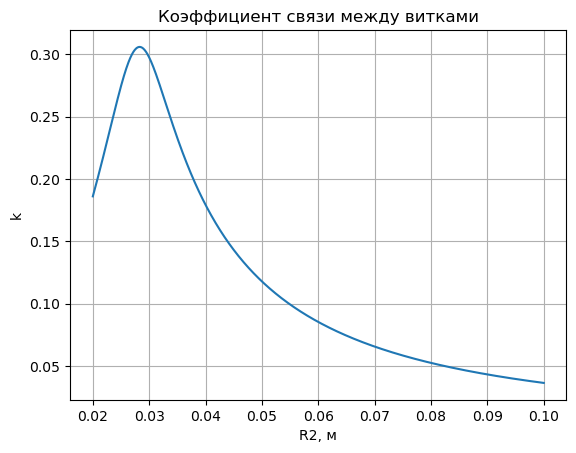

In [107]:
# расчёт коэффициента связи
k_r1r2 = calc_coupling_coefficient(coil_1, coil_2, d)
# отображение графика
plot(coil_2, k_r1r2, x_label="R2, м", y_label="k", title="Коэффициент связи между витками")

In [108]:
# максимум kmax
print(f"kmax = {np.max(k_r1r2)} при R = {coil_2[np.argmax(k_r1r2)]} м")

kmax = 0.3059353210953747 при R = 0.02832832832832833 м


## Применение "steepest ascent hill climbing" к оптимизации формы катушки ##

In [111]:
# steepest hill climbing algorithm для поиска максимума функции
def mutation(start, finish, x, r=0.01):
    return np.random.uniform(low=start if x - r < start else x - r, high=finish if x + r > finish else x + r)

good_mutation = []
bad_mutation = []
all_mutation = []

r2 = np.random.uniform(low=0.02, high=0.1)
thr = 1e-3

while True:
    fit_k = calc_coupling_coefficient(coil_1, r2, d=d)
    r2_q = mutation(x=r2, start=0.02, finish=0.1)
    fit_kq = calc_coupling_coefficient(coil_1, r2_q, d=d)
    if fit_kq > fit_k:
        good_mutation.append((r2_q, fit_kq))
        r2 = r2_q
        fit_k = fit_kq
    else:
        bad_mutation.append((r2_q, fit_kq))
    all_mutation.append((r2_q, fit_kq))
    # новый критерий остановки алгоритма
    if len(good_mutation) >= 2 and (good_mutation[-1][1] - good_mutation[-2][1]) < thr:
        break

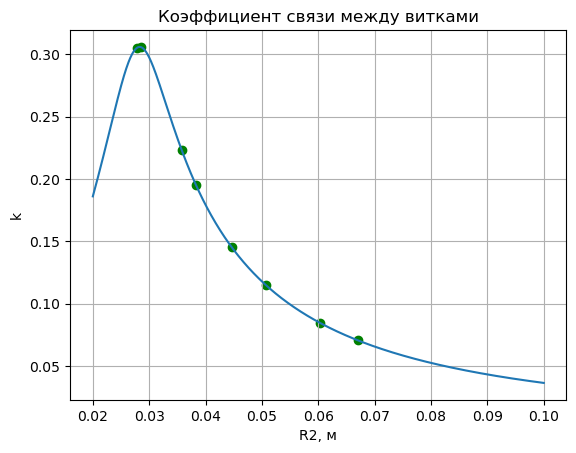

kmax = 0.30572789392063104; R2max = 0.02855857502651682 м
Количество полезных мутаций: 8
Количество вредных мутаций: 19
Всего мутаций: 27


In [112]:
plot(coil_2, k_r1r2, x_label="R2, м", y_label="k",
     title="Коэффициент связи между витками", g_points=good_mutation)
print(f"kmax = {fit_k}; R2max = {r2} м")
print(f"Количество полезных мутаций: {len(good_mutation)}")
print(f"Количество вредных мутаций: {len(bad_mutation)}")
print(f"Всего мутаций: {len(all_mutation)}")